# Introduction

The excitement level of millions of people rises each October as the NHL season begins. 31 teams, each playing 82 games, with the top teams qualifying to the Stanley Cup playoffs. The NHL is split into 2 conferences, East and West, with each conference further split into 2 Divisions. 8 teams from each conference qualify for the playoffs: the top 3 teams in each division, plus 2 “wild card” teams from each conference. These wild card teams are the ones that finish and in their conference. Can we use previous years data to predict which teams should be in the playoffs this year? This is the question we are trying to answer. As of writing this report, the regular season has ended, so we can compare our machine-learned predictions to reality.

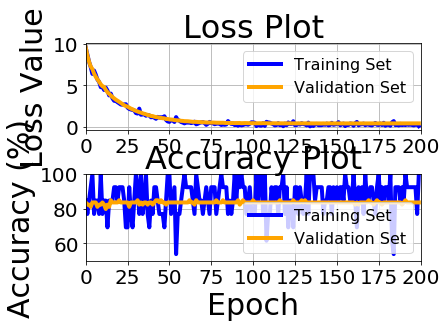


Training Set Accuracy is:  [100.]
Validation Set Accuracy is:  [83.54430389]

Eastern Playoff Prediction:
 Tampa Bay Lightning vs. Carolina Hurricanes

 Boston Bruins vs. Toronto Maple Leafs

 New York Islanders vs. Montreal Canadiens

 Pittsburgh Penguins vs. Washington Capitals

Western Playoff Prediction:
 Calgary Flames vs. Colorado Avalanche

 Vegas Golden Knights vs. San Jose Sharks

 Nashville Predators vs. Dallas Stars

 St. Louis Blues vs. Winnipeg Jets


In [3]:
import tensorflow as tf
import numpy as np
import plotter as plt
from genData import Data
from sklearn.utils import shuffle


def buildGraph(dim, alpha,dropProb, hiddenUnits):
    tf.reset_default_graph() # Clear any previous junk
    tf.set_random_seed(421)

    X = tf.placeholder(tf.float32, [None, dim], name='inputs') # Placeholder for input
    yTarget = tf.placeholder(tf.float32, [None,2], name= 'targets') # Placeholder for targets
    reg = tf.placeholder(tf.float32,None, name='regulaizer') # Regularization Placeholder
    isTraining = tf.placeholder(tf.bool) # Used for Dropout

    weights = {  # Dictionary for the different weights. Used He Initialization
    'w1': tf.get_variable('W1', shape=(dim,hiddenUnits), initializer=tf.initializers.he_uniform()),
    'w2': tf.get_variable('W2', shape=(hiddenUnits,hiddenUnits), initializer=tf.initializers.he_uniform()),
    'w3': tf.get_variable('W3', shape=(hiddenUnits,2), initializer=tf.initializers.he_uniform()),

}
    biases = { # Dictionary for the different biases. Used He Initialization
    'b1': tf.get_variable('B1', shape=(hiddenUnits), initializer=tf.initializers.he_uniform()),
    'b2': tf.get_variable('B2', shape=(hiddenUnits), initializer=tf.initializers.he_uniform()),
    'b3': tf.get_variable('B3', shape=(2), initializer=tf.initializers.he_uniform()),

}

    layer1 = tf.nn.bias_add(tf.matmul(X, weights['w1']), biases['b1']) # Dot product for first layer
    x1 = tf.nn.relu(layer1) # ReLu Layer1

    layer2 = tf.nn.bias_add(tf.matmul(x1, weights['w2']), biases['b2']) # Dot product to make the second layer
    toReLU = tf.cond(isTraining, lambda: tf.nn.dropout(layer2, rate = dropProb), lambda: layer2) # Insert condition for dropout or not. Dropout only used when training
    x2 = tf.nn.relu(toReLU) # ReLu based on condition

    predict = tf.nn.bias_add(tf.matmul(x2, weights['w3']), biases['b3']) # Dot product to make the last layer

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=yTarget, logits=predict)) +reg*(tf.nn.l2_loss(weights['w1']) + tf.nn.l2_loss(weights['w2'])+tf.nn.l2_loss(weights['w3'])) # Loss function

    outputClass = tf.argmax(predict, axis=1) # Choose whether team made the playoffs (0) or did not (1) based on highest probability
    correctPrediction = tf.equal(outputClass, tf.argmax(yTarget, 1)) # Find number of correct predictions made compared to the labels
    accuracy = tf.reduce_mean(tf.cast(correctPrediction, "float"))*100 # Find average accuracy

    optimizer = tf.train.AdamOptimizer(learning_rate = alpha).minimize(loss) # Use Adam Optimizer
    return optimizer, loss, X, yTarget, reg, accuracy, predict, isTraining

def DeepNet():
### Parameters you can vary ###
    alpha = 1e-3 # Learning Rate
    batch_size = 13 # Batch size. Number must be a factor of training set size
    features = 3 # Number of features you want to use
    dropProb = 0.5 # dropout probability
    epochs = 200 # Number of Epochs  
    hiddenUnits = 500 # Number of hidden layers
    regularization = 0.01 # Regularizastion term
    a = Data(False,features) # Change to True if you want to find the top X features. If set to False, this will use the top 3 features that are set as SV%, EVGF, and EVGA 
### End of Parameter you can vary ###

    trainData, trainTarget, validData, validTarget, testData = a.featureExtractor() # Condense number of columns to top X features
    trainTarget = a.convertOneHot(trainTarget) # One hot training targets
    validTarget = a.convertOneHot(validTarget) # One hot validation targets

    # Initialize containers for plotting
    trainLoss = np.full((epochs, 1), np.inf) 
    validLoss = np.full((epochs, 1), np.inf)
    trainAcc = np.zeros((epochs,1))
    validAcc = np.zeros((epochs,1))

    optimizer, loss, X, labels, reg, accuracy, predict, isTraining = buildGraph(features, alpha, dropProb, hiddenUnits)
    init = tf.global_variables_initializer()   
    with tf.Session() as sess:
        sess.run(init)
        batch_number = int(trainTarget.shape[0]/batch_size) # Calculate batch number

        for i in range(epochs): # Loop across epochs
            trainData, trainTarget = shuffle(trainData,trainTarget) # Shuffle training data each epoch

            # Split into the number of batches
            X_split = np.split(trainData,batch_number) 
            Y_split = np.split(trainTarget,batch_number) 
            
            for j in range(len(X_split)): # Loop through each batch
           # Let us OPTIMIZE! Set isTraining to True to enable dropout for training only
                _, trainLoss[i], trainAcc[i] = sess.run([optimizer,loss,accuracy], feed_dict = {X: X_split[j], labels: Y_split[j], reg: regularization, isTraining:True})

            validLoss[i], validAcc[i]= sess.run([loss,accuracy], feed_dict = {X: validData, labels: validTarget, reg: regularization, isTraining:False})


        plt.logNet(trainLoss,validLoss,trainAcc,validAcc,epochs) # Plot 
        print("\nTraining Set Accuracy is: ", trainAcc[-1])
        print("Validation Set Accuracy is: ", validAcc[-1])

        predictor = sess.run([predict], feed_dict = {X: testData,isTraining: False}) # Predict for this year

       
        sess.close()
        
    return testData, predictor

   
if __name__ == "__main__":
    testData, predictor = DeepNet()
    predictor=np.reshape(np.asarray(predictor),(-1,2))
    plt.postProcess(testData,predictor)